In [1]:
# Cell 1: 💡 Install & Imports
# (uncomment if needed)
# !pip install prophet pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_theme(style="whitegrid")

In [3]:
# Cell 2: 🔧 Generate Synthetic Supply-Chain Sales Data
np.random.seed(42)
# create a date range covering 3 years of daily data
dates = pd.date_range(start="2022-01-01", end="2024-12-31", freq="D")
# simulate a baseline seasonal pattern + noise
sales = (
    200
    + 20 * np.sin(2 * np.pi * dates.dayofyear / 365.25)      # yearly seasonality
    + 10 * np.sin(2 * np.pi * dates.dayofweek / 7)           # weekly seasonality
    + np.random.normal(0, 5, len(dates))                     # noise
)
df = pd.DataFrame({"date": dates, "sales": sales})
df.head()

,date,sales
0,2022-01-01,193.078323
1,2022-01-02,192.178325
2,2022-01-03,204.270130
3,2022-01-04,216.808572
4,2022-01-05,210.296634


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1096 non-null   datetime64[ns]
 1   sales   1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.3 KB
None
                      date        sales
count                 1096  1096.000000
mean   2023-07-02 12:00:00   200.155514
min    2022-01-01 00:00:00   161.974552
25%    2022-10-01 18:00:00   187.134304
50%    2023-07-02 12:00:00   200.538093
75%    2024-04-01 06:00:00   212.712394
max    2024-12-31 00:00:00   239.304379
std                    NaN    16.389979


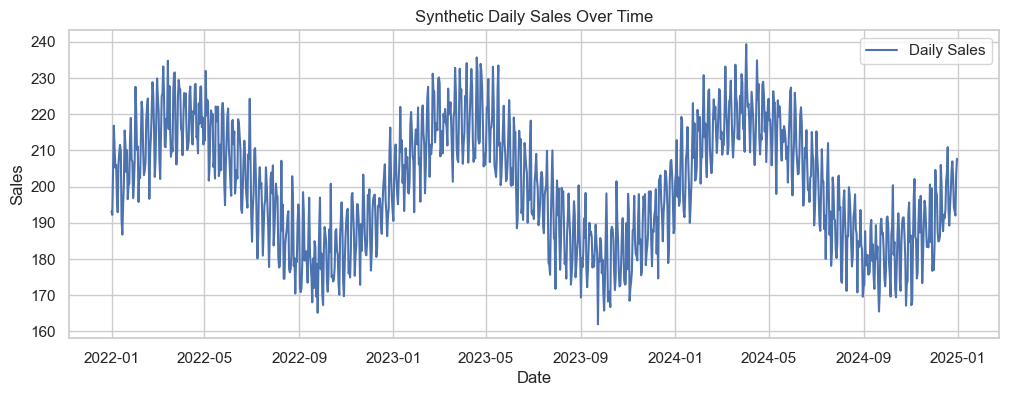

In [5]:
# Cell 3: 🔎 Exploratory Data Analysis
print(df.info())
print(df.describe())

plt.figure(figsize=(12,4))
plt.plot(df["date"], df["sales"], label="Daily Sales")
plt.title("Synthetic Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [7]:
# Cell 4: 🛠️ Prepare for Prophet
# Prophet expects columns "ds" (date) and "y" (value)
ts = df.rename(columns={"date": "ds", "sales": "y"})
# Example of adding a synthetic regressor (e.g., promotion flag)
# let's say every 30th day has a promotion
ts["promo"] = (ts.index % 30 == 0).astype(int)

In [9]:
# Cell 5: 🚀 Train Prophet Model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative"
)
model.add_regressor("promo")
model.fit(ts)


19:49:36 - cmdstanpy - INFO - Chain [1] start processing
19:49:36 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Cell 6: 🔮 Create Forecast
future = model.make_future_dataframe(periods=90)  # next 90 days
# generate corresponding promo flags for the future period
future["promo"] = (future.index % 30 == 0).astype(int)
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
1181,2025-03-27,224.782385,218.664103,230.697607
1182,2025-03-28,216.554888,210.382593,222.626912
1183,2025-03-29,211.000689,204.810333,217.023565
1184,2025-03-30,212.767919,206.586657,218.822402
1185,2025-03-31,219.735302,213.222479,226.174092


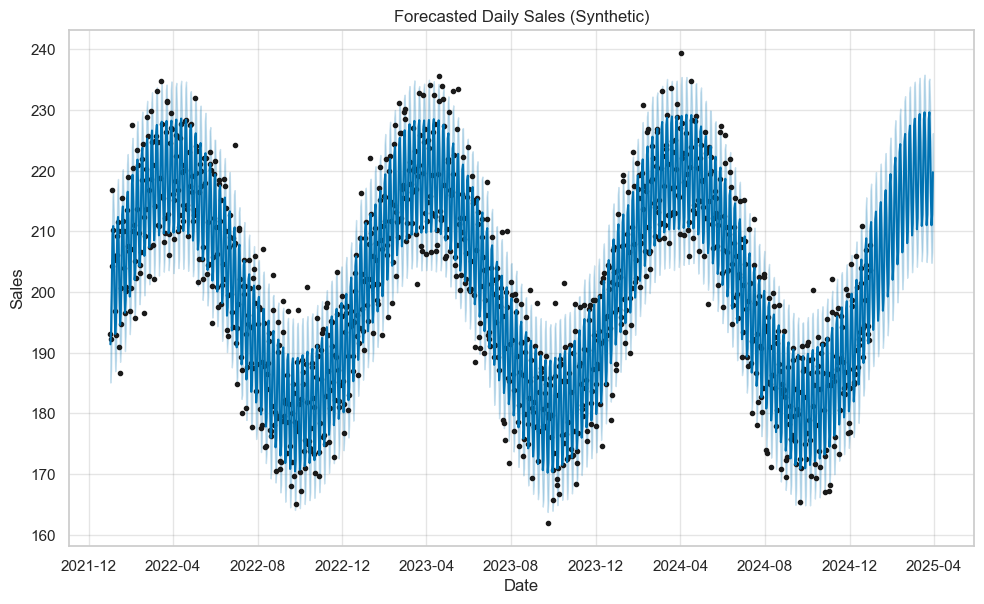

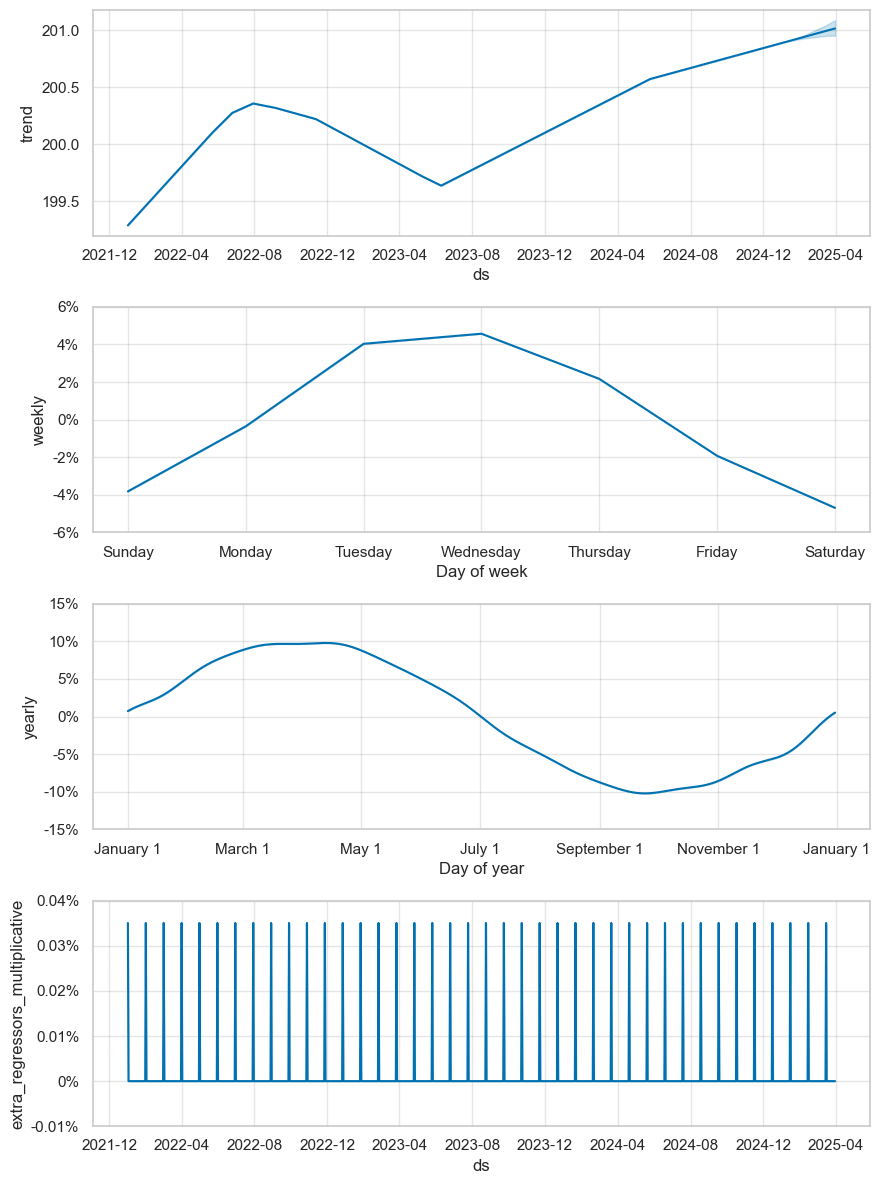

In [13]:
# Cell 7: 📊 Visualize Forecast
fig1 = model.plot(forecast)
plt.title("Forecasted Daily Sales (Synthetic)")
plt.xlabel("Date")
plt.ylabel("Sales")

fig2 = model.plot_components(forecast)
plt.show()


In [15]:
# Cell 8: 📈 Evaluate on Historical Hold-out
cutoff = -90
train = ts.iloc[:cutoff]
test  = ts.iloc[cutoff:]
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative"
)
m.add_regressor("promo")
m.fit(train)
future_train = m.make_future_dataframe(periods=90)
future_train["promo"] = (future_train.index % 30 == 0).astype(int)
pred = m.predict(future_train).set_index("ds")["yhat"]
actual = test.set_index("ds")["y"]
mae = mean_absolute_error(actual, pred.loc[test.ds])
rmse = mean_squared_error(actual, pred.loc[test.ds], squared=False)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


19:49:55 - cmdstanpy - INFO - Chain [1] start processing
19:49:55 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3.72, RMSE: 4.70


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Cell 9: 📝 Conclusions & Next Steps
# - Review MAE/RMSE on synthetic data; compare with real-world benchmarks
# - Experiment with additional regressors (inventory, lead time, holidays)
# - Try advanced ensembles (Darts) or real-time streaming forecasts
